<a href="https://colab.research.google.com/github/MengOonLee/LLM/blob/main/References/LangChain/ipynb/Academy/LangChain/Quickstart/L1_fast_agent-Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Agent - Build a SQL Agent fast!

<img src="https://github.com/MengOonLee/LLM/blob/main/References/LangChain/ipynb/Academy/LangChain/Quickstart/assets/LC_L1_Top.png?raw=true" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [ ]:
%%bash
apt install -y zstd
apt install -y pciutils lshw
curl -fsSL https://ollama.com/install.sh | sh
pip install --no-cache-dir -qU \
    langchain langgraph langchain-core langchain-community \
    langchain-ollama ollama

In [ ]:
!nohup ollama serve &

In [ ]:
!ollama pull gpt-oss:20b

In [3]:
import warnings
warnings.filterwarnings("ignore")
import langchain_ollama

llm = langchain_ollama.ChatOllama(
    model="gpt-oss:20b",
    temperature=0,
    validate_model_on_init=True
)
llm

ChatOllama(model='gpt-oss:20b', validate_model_on_init=True, temperature=0.0)

In [4]:
messages = [
    (
        "system", """
            You are a helpful assistant that translates English to French.
            Translate the user sentence.
        """,
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content='J’aime programmer.', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2026-02-07T08:06:13.512253596Z', 'done': True, 'done_reason': 'stop', 'total_duration': 58270483950, 'load_duration': 56440772579, 'prompt_eval_count': 98, 'prompt_eval_duration': 520205431, 'eval_count': 50, 'eval_duration': 1074922563, 'logprobs': None, 'model_name': 'gpt-oss:20b', 'model_provider': 'ollama'}, id='lc_run--019c3722-3766-7812-b35d-d91dc0a7e614-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 98, 'output_tokens': 50, 'total_tokens': 148})

Initialize LLM model

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import langchain_huggingface

_ = dotenv.load_dotenv(dotenv_path=".env", override=True)

# repo_id = "Qwen/Qwen2.5-7B-Instruct"
repo_id = "Qwen/Qwen3-4B-Instruct-2507"
llm_endpoint = langchain_huggingface.HuggingFaceEndpoint(
    huggingfacehub_api_token=os.environ['HF_TOKEN'], provider='auto',
    repo_id=repo_id, temperature=0.1)
llm = langchain_huggingface.ChatHuggingFace(llm=llm_endpoint)

In [5]:
from langchain_community import utilities

db = utilities.SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [6]:
from dataclasses import dataclass

from langchain_community import utilities

# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: utilities.SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [7]:
from langchain_core.tools import tool
from langgraph import runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtimes = runtime.get_runtime(RuntimeContext)
    db = runtimes.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [8]:
SYSTEM_PROMPT = """
You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list.

In [9]:
from langchain import agents

agent = agents.create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext
)

Here's a display of the agent ReAct Loop.

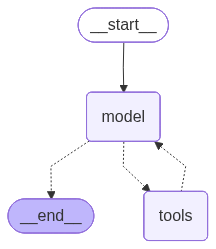

In [10]:
from IPython import display

display.display(display.Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [13]:
question = """
Which table has the largest number of entries?
"""

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================


Which table has the largest number of entries?

================================== Ai Message ==================================
Tool Calls:
  execute_sql (f6a33c00-2b8f-4944-83b1-e8901877b6ae)
 Call ID: f6a33c00-2b8f-4944-83b1-e8901877b6ae
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (150258db-4054-4908-951c-fdb67e0ab4fa)
 Call ID: 150258db-4054-4908-951c-fdb67e0ab4fa
  Args:
    query: SELECT 'Album' AS table_name, COUNT(*) AS cnt FROM Album
UNION ALL
SELECT 'Artist', COUNT(*) FROM Arti

In [14]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (b39ab615-2e80-4b9d-ae41-0fc0bfdc5603)
 Call ID: b39ab615-2e80-4b9d-ae41-0fc0bfdc5603
  Args:
    query: PRAGMA table_info(tracks);
================================= Tool Message =================================
Name: execute_sql


================================== Ai Message ==================================
Tool Calls:
  execute_sql (b7830fc5-fbb6-4556-8278-f03739626c02)
 Call ID: b7830fc5-fbb6-4556-8278-f03739626c02
  Args:
    query: SELECT name, type FROM pragma_table_info('tracks');
================================= Tool Message =================================
Name: execute_sql


================================== Ai Message ==================================
Tool Calls:
  execute_sql (1b3a7e56-da66-40f8-b06a-d1f741180dcf)
 Call ID: 1b3a7e56-d

In [15]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (21c2fe2f-7bed-4a4e-87df-c1afcd93ba24)
 Call ID: 21c2fe2f-7bed-4a4e-87df-c1afcd93ba24
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Here are all the tables in the database:

| Table Name     |
|----------------|
| Album          |
| Artist         |
| Customer       |
| Employee       |
| Genre          |
| Invoice        |
| InvoiceLine    |
| MediaType      |
| Playlist       |
| PlaylistTrack  |
| Track   